# Taller 2 DeepVogue
### ¿Puede ser la moda un tema profundo?

Este es un taller abierto y competitivo en que debe diseñar, implementar, y evaluar una solución a un problema real usando redes neuronales.


<table align='left'>
<tr>
<td><img src='https://i0.wp.com/www.printivity.com/insights/wp-content/uploads/2019/08/catalog-qr-code.jpeg?fit=6000%2C4000&ssl=1' width='700'/> </td>
</tr>
</table>



# Problema & Datos

> **Problema:** DeepVogue, tienda de modas online, le solicita construir un sistema que permita a un usuario cargar una imagen
de una prenda de vestir y encontrar ítems similares en el catálogo de la tienda. Para simplificar, usaremos como catálogo (base de datos) el mismo conjunto de imágenes prueba, de modo que el problema se reduce a relacionar cada imagen de pruebas con otras imágenes del mismo conjunto. Asumiremos que el usuario desea encontrar a lo más *10 prendas similares* a cada query y que para determimar similaridad, el usuario espera que se trate de la misma categoría de vestir, y que se compartan atributos como textura, materiales, diseño, y estilo. 

> **Imágenes:** Usted dispondrá de imágenes de artículos de moda extraídos de un sitio real de ventas por internet. La colección estará dividida en 3 subconjuntos: train (entrenamiento), val (validación), y test (pruebas). Las carpetas han sido zipeadas a los archivos: *image_data_train.zip*, *image_data_val.zip*, e *image_data_test.zip*. 


## Metadata

En muchos problemas de este tipo (recuperación de imágenes), sólo se dispone de las imágenes. Sin embargo, para facilitar las cosas, usted dispondrá de metadatos que le permitirán definir una estrategia de aprendizaje más supervisada y le permitirán guiar la búsqueda posterior.

> **Boxes:** Para cada imagen se incluirá un bounding box que indica en qué está poniendo atención el usuario al hacer la búsqueda. Esta información no está disponible para todas las imágenes, incluidas las imágenes de pruebas. 

> **Categorías:** Cada imagen de entrenamiento y validación está clasificada en una categoría en la que la tienda expone la prenda. La categoría está identificada en la carpeta correspondiente a cada imagen. Esta información no está disponible para las imágenes de pruebas. 

> **Atributos:** Cada imagen de entrenamiento y validación está anotada considerando 1000 atributos **no exclyentes** relacionados con textura, materiales, diseño, y estilo. Esta información se encuentra en los archivos *metadata_train.csv* y *metadata_val.csv*. Esta información no está disponible para las imágenes de pruebas. Por si desea más información, el significado de cada atributo está especificado el archivo description_attributes.csv.


## Envio de Predicciones

Para que sea todo muy claro, contará con un ejemplo del o formato en que debe subir sus predicciones a la competencia:  *ejemplo_submission_file*. Tendrá también un archivo con los identificadores de las imágenes a predecir, pero sin las predicciones: *empy_solution_file.csv*. Finalmente, tendrá también una muestra de 500 resultados correctos: *sample_solution_key_KAGGLE.csv*.

El conjunto de imágenes de test contiene 54430 imágenes, enumeradas como "test_item0.jpg", "test_item1.jpg", etc. Sin embargo, usted debe entregar resultados para sólo para las 5427 imágenes con identificadores en el archivo "solution_empty.csv" ya que las imágenes "test_item8782.jpg", "test_item45571.jpg", y "test_item54157.jpg" fueron exluidas por no tener imágenes similares claras en el catálogo. Es importante notar que los identificadores de las imágenes de pruebas en el archivo que debe subir a Kaggle corresponden al número incluido en el nombre. Es decir, el id 0 corresponde a la imagen test_item0.jpg", el id 1 corresponde a la imagen test_item1.jpg", etc.

## Métrica

La métrica de la competencia será MAP@100 (mean average precision @k con k=100). MAP@k es actualmente la métrica más utilizada para evaluar resultados en *recuperación de información*. En resumen, esta métrica se maximiza cuando los resultados más similares a la imagen query están al comienzo de la lista de resultados. Se usará k=100 para considerar resultados correctos que quizás no estén en las primeras 10 posiciones de la lista como espera el usuario.

Más específicamente, si $d_{1}, d_{2}, \ldots, d_{n_q}$ es la lista de artículos similares que usted devuelve para una query $q$, la precisión de la lista de resultados hasta la posición $k$ se mide como

\begin{align}
P@k = \frac{1}{k} \sum_{i=1}^{L_q} R(q,d_i)
\end{align}

donde $R(q,d_i)$ indica si el resultado $d_i$ es relevante para la query (es decir, que el usuario está satisfecho con el resultado), $L_q = \mbox{min}(n_q,k)$, y $n_q$ es el número de resultados entregados (puede ser más o menos que k). A partir de $P@k$, se define la precisión media hasta la posición $k$ como

\begin{align}
\mbox{AP@k} =  \frac{1}{\mbox{min}(m_q,k)}\sum_{i=1}^{k} P@i \cdot R(q,d_i) \, ,
\end{align}

donde $m_q$ es el número de imágenes similares a $q$ dentro del catálogo. 

# Base Imports

In [2]:
from tensorflow import keras
import seaborn as sns
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import os

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, TimeDistributed, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.preprocessing.image import load_img, img_to_array



# Carga de Datos

# Posibles Enfoques

Un enfoque sencillo al problema es usar la imagen para predecir la categoría y el resto de los atributos. Luego, es posible relacionar imágenes de prueba a partir de los metadatos predichos. 

# Load Images

In [3]:
BATCH_SIZE = 32
RES_ESPACIAL = 128
CHANNELS = 3

def load_data(path,batch_size,res=RES_ESPACIAL):
  return tf.keras.utils.image_dataset_from_directory(
    path,
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(res,res),
    shuffle=True)

reduced_train_images = load_data("C:/Users/je00m/Downloads/deepvogue/image_data_reduced_train/content/image_data/reduced_train_images/",batch_size=BATCH_SIZE, res=RES_ESPACIAL)

Found 37020 files belonging to 46 classes.


In [4]:
train_images = load_data("C:/Users/je00m/Downloads/deepvogue/image_data_train/content/image_data/train_images/",batch_size=BATCH_SIZE, res=RES_ESPACIAL)

Found 185101 files belonging to 46 classes.


In [5]:
val_images = load_data("C:/Users/je00m/Downloads/deepvogue/image_data_val/content/image_data/val_images/",batch_size=BATCH_SIZE, res=RES_ESPACIAL)

Found 46276 files belonging to 46 classes.


In [6]:
def load_labels(folder_path):
    """
    Carga las etiquetas (nombres de las carpetas) de un directorio dado.

    Parameters:
        folder_path (str): ruta al directorio que contiene las carpetas de etiquetas.

    Returns:
        labels (list): lista de etiquetas (nombres de las carpetas).

    """
    labels = []
    subfolders = sorted(os.listdir(folder_path))
    for label in subfolders:
        labels.append(label)
    return labels

In [41]:
train_images_labels = load_labels("C:/Users/come_/Documents/UNIVERSIDAD/Redes Neuronales/Taller 2/deepvogue/image_data_train/content/image_data/train_images/")

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Definir el generador de imágenes
image_generator = ImageDataGenerator()

# Generar el conjunto de datos desde el directorio de imágenes
data_directory = 'C:/Users/come_/Documents/UNIVERSIDAD/Redes Neuronales/Taller 2/deepvogue/image_data_train/content/image_data/train_images/'
batch_size = 32
image_size = (128, 128)

data_generator = image_generator.flow_from_directory(
    data_directory,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Obtener las imágenes y las etiquetas del conjunto de datos
images = []
labels = []

for i in range(len(data_generator)):
    batch_images, batch_labels = data_generator[i]
    images.extend(batch_images)
    labels.extend(batch_labels)

# Verificar los resultados
print("Número de imágenes:", len(images))
print("Número de etiquetas:", len(labels))


Found 185101 images belonging to 46 classes.


In [26]:
empy_solution_file_df = pd.read_csv("C:/Users/come_/Documents/UNIVERSIDAD/Redes Neuronales/Taller 2/deepvogue/empy_solution_file.csv")


empy_solution_file_df.head()

In [28]:
ejemplo_submission_file_df = pd.read_csv("C:/Users/come_/Documents/UNIVERSIDAD/Redes Neuronales/Taller 2/deepvogue/ejemplo_submission_file.csv")


ejemplo_submission_file_df.head()

In [79]:
import os
import csv

image_dir = "C:/Users/come_/Documents/UNIVERSIDAD/Redes Neuronales/Taller 2/deepvogue/image_data_reduced_train/content/image_data/reduced_train_images/"
output_file = "train_labels.csv"

# Obtener la lista de carpetas de vestimentas
categories = os.listdir(image_dir)

# Crear y abrir el archivo CSV en modo de escritura
with open(output_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['image_path', 'category'])  # Escribir los encabezados de las columnas

    # Recorrer las carpetas de vestimentas y las imágenes dentro de cada carpeta
    for category in categories:
        category_dir = os.path.join(image_dir, category)
        if os.path.isdir(category_dir):
            image_files = os.listdir(category_dir)
            for image_file in image_files:
                image_path = os.path.join(category_dir, image_file)
                writer.writerow([image_path, category])


##### Otro approach:
Pero aquí no supimos qué hacer con esta información así que seguimos con otras ideas.

In [83]:
train_labels = pd.read_csv("C:/Users/come_/Documents/UNIVERSIDAD/Redes Neuronales/Taller 2/deepvogue/train_labels.csv")

train_labels

,image_path,category
0,C:/Users/come_/Documents/UNIVERSIDAD/Redes Neu...,Anorak
1,C:/Users/come_/Documents/UNIVERSIDAD/Redes Neu...,Anorak
2,C:/Users/come_/Documents/UNIVERSIDAD/Redes Neu...,Anorak
3,C:/Users/come_/Documents/UNIVERSIDAD/Redes Neu...,Anorak
4,C:/Users/come_/Documents/UNIVERSIDAD/Redes Neu...,Anorak
...,...,...
37015,C:/Users/come_/Documents/UNIVERSIDAD/Redes Neu...,Turtleneck
37016,C:/Users/come_/Documents/UNIVERSIDAD/Redes Neu...,Turtleneck
37017,C:/Users/come_/Documents/UNIVERSIDAD/Redes Neu...,Turtleneck
37018,C:/Users/come_/Documents/UNIVERSIDAD/Redes Neu...,Turtleneck


## Exploratory Data Analysis:
Exploremos un poco los archivos para ver qué pasa con ellos. 

In [31]:
class_names = train_images.class_names
print(class_names)

['Anorak', 'Blazer', 'Blouse', 'Bomber', 'Button-Down', 'Caftan', 'Capris', 'Cardigan', 'Chinos', 'Coat', 'Coverup', 'Culottes', 'Cutoffs', 'Dress', 'Flannel', 'Gauchos', 'Halter', 'Henley', 'Hoodie', 'Jacket', 'Jeans', 'Jeggings', 'Jersey', 'Jodhpurs', 'Joggers', 'Jumpsuit', 'Kaftan', 'Kimono', 'Leggings', 'Onesie', 'Parka', 'Peacoat', 'Poncho', 'Robe', 'Romper', 'Sarong', 'Shorts', 'Skirt', 'Sweater', 'Sweatpants', 'Sweatshorts', 'Tank', 'Tee', 'Top', 'Trunks', 'Turtleneck']


Tenemos 46 categorías que son las de arriba.

In [32]:
print(len(class_names))

46


Luego, se creó un diccionario donde anexamos cada categoría con el número de imágenes en ella.
Lo guardamos con Pickle solo por si lo volviésemos a necesitar (se demoró muchísimo en iterar para crear el diccionario así que mejor era guardarlo por si acaso).

In [42]:
class_count = {}
label_names = ['Anorak', 'Blazer', 'Blouse', 'Bomber', 'Button-Down', 'Caftan', 
               'Capris', 'Cardigan', 'Chinos', 'Coat', 'Coverup', 'Culottes', 'Cutoffs', 
               'Dress', 'Flannel', 'Gauchos', 'Halter', 'Henley', 'Hoodie', 'Jacket', 'Jeans', 
               'Jeggings', 'Jersey', 'Jodhpurs', 'Joggers', 'Jumpsuit', 'Kaftan', 'Kimono', 'Leggings', 
               'Onesie', 'Parka', 'Peacoat', 'Poncho', 'Robe', 'Romper', 'Sarong', 'Shorts', 'Skirt', 'Sweater', 
               'Sweatpants', 'Sweatshorts', 'Tank', 'Tee', 'Top', 'Trunks', 'Turtleneck']

for img, label in train_images:
    class_name = label_names[label.numpy().argmax()]
    if class_name in class_count:
        class_count[class_name] += 1
    else:
        class_count[class_name] = 1
print(class_count)


{'Dress': 1452, 'Skirt': 307, 'Blazer': 156, 'Tee': 743, 'Tank': 294, 'Jumpsuit': 136, 'Romper': 162, 'Shorts': 395, 'Blouse': 478, 'Cutoffs': 32, 'Cardigan': 244, 'Jersey': 21, 'Sweatpants': 59, 'Jacket': 203, 'Joggers': 82, 'Jeans': 149, 'Hoodie': 82, 'Top': 197, 'Coat': 42, 'Kimono': 40, 'Culottes': 12, 'Parka': 13, 'Sweater': 261, 'Trunks': 8, 'Chinos': 8, 'Leggings': 99, 'Henley': 16, 'Sweatshorts': 25, 'Turtleneck': 3, 'Bomber': 7, 'Anorak': 3, 'Poncho': 16, 'Robe': 4, 'Flannel': 5, 'Button-Down': 5, 'Jeggings': 15, 'Capris': 2, 'Caftan': 1, 'Peacoat': 2, 'Gauchos': 1, 'Jodhpurs': 1, 'Kaftan': 3, 'Onesie': 1}


In [47]:
import pickle


# Guardar el diccionario en un archivo
with open('dict.pickle', 'wb') as f:
    pickle.dump(class_count, f)

# Cargar el diccionario desde el archivo
with open('dict.pickle', 'rb') as f:
    loaded_dict = pickle.load(f)

# Imprimir el diccionario cargado
print(loaded_dict)

{'Dress': 1452, 'Skirt': 307, 'Blazer': 156, 'Tee': 743, 'Tank': 294, 'Jumpsuit': 136, 'Romper': 162, 'Shorts': 395, 'Blouse': 478, 'Cutoffs': 32, 'Cardigan': 244, 'Jersey': 21, 'Sweatpants': 59, 'Jacket': 203, 'Joggers': 82, 'Jeans': 149, 'Hoodie': 82, 'Top': 197, 'Coat': 42, 'Kimono': 40, 'Culottes': 12, 'Parka': 13, 'Sweater': 261, 'Trunks': 8, 'Chinos': 8, 'Leggings': 99, 'Henley': 16, 'Sweatshorts': 25, 'Turtleneck': 3, 'Bomber': 7, 'Anorak': 3, 'Poncho': 16, 'Robe': 4, 'Flannel': 5, 'Button-Down': 5, 'Jeggings': 15, 'Capris': 2, 'Caftan': 1, 'Peacoat': 2, 'Gauchos': 1, 'Jodhpurs': 1, 'Kaftan': 3, 'Onesie': 1}


In [43]:
creciente_class_count = sorted(class_count.items(), key=lambda x: x[1])
print(creciente_class_count)

[('Caftan', 1), ('Gauchos', 1), ('Jodhpurs', 1), ('Onesie', 1), ('Capris', 2), ('Peacoat', 2), ('Turtleneck', 3), ('Anorak', 3), ('Kaftan', 3), ('Robe', 4), ('Flannel', 5), ('Button-Down', 5), ('Bomber', 7), ('Trunks', 8), ('Chinos', 8), ('Culottes', 12), ('Parka', 13), ('Jeggings', 15), ('Henley', 16), ('Poncho', 16), ('Jersey', 21), ('Sweatshorts', 25), ('Cutoffs', 32), ('Kimono', 40), ('Coat', 42), ('Sweatpants', 59), ('Joggers', 82), ('Hoodie', 82), ('Leggings', 99), ('Jumpsuit', 136), ('Jeans', 149), ('Blazer', 156), ('Romper', 162), ('Top', 197), ('Jacket', 203), ('Cardigan', 244), ('Sweater', 261), ('Tank', 294), ('Skirt', 307), ('Shorts', 395), ('Blouse', 478), ('Tee', 743), ('Dress', 1452)]


(En estas dos casillas que siguen intentamos algo que leímos sobre guardar datos con %store que después de reiniciar el kernel no se borran. Efectivamente funciona.)

In [50]:
%store class_count
%store creciente_class_count
%store loaded_dict

Stored 'class_count' (dict)
Stored 'creciente_class_count' (list)
Stored 'loaded_dict' (dict)


In [5]:
#restore kernel
%store -r class_count
%store -r creciente_class_count
%store -r loaded_dict

Finalmente, graficamos las categorías para ver cómo se comportan las clases. 
Podemos notar que no están balanceadas.

In [6]:
class_count

{'Dress': 1452,
 'Skirt': 307,
 'Blazer': 156,
 'Tee': 743,
 'Tank': 294,
 'Jumpsuit': 136,
 'Romper': 162,
 'Shorts': 395,
 'Blouse': 478,
 'Cutoffs': 32,
 'Cardigan': 244,
 'Jersey': 21,
 'Sweatpants': 59,
 'Jacket': 203,
 'Joggers': 82,
 'Jeans': 149,
 'Hoodie': 82,
 'Top': 197,
 'Coat': 42,
 'Kimono': 40,
 'Culottes': 12,
 'Parka': 13,
 'Sweater': 261,
 'Trunks': 8,
 'Chinos': 8,
 'Leggings': 99,
 'Henley': 16,
 'Sweatshorts': 25,
 'Turtleneck': 3,
 'Bomber': 7,
 'Anorak': 3,
 'Poncho': 16,
 'Robe': 4,
 'Flannel': 5,
 'Button-Down': 5,
 'Jeggings': 15,
 'Capris': 2,
 'Caftan': 1,
 'Peacoat': 2,
 'Gauchos': 1,
 'Jodhpurs': 1,
 'Kaftan': 3,
 'Onesie': 1}

In [7]:
creciente_class_count

[('Caftan', 1),
 ('Gauchos', 1),
 ('Jodhpurs', 1),
 ('Onesie', 1),
 ('Capris', 2),
 ('Peacoat', 2),
 ('Turtleneck', 3),
 ('Anorak', 3),
 ('Kaftan', 3),
 ('Robe', 4),
 ('Flannel', 5),
 ('Button-Down', 5),
 ('Bomber', 7),
 ('Trunks', 8),
 ('Chinos', 8),
 ('Culottes', 12),
 ('Parka', 13),
 ('Jeggings', 15),
 ('Henley', 16),
 ('Poncho', 16),
 ('Jersey', 21),
 ('Sweatshorts', 25),
 ('Cutoffs', 32),
 ('Kimono', 40),
 ('Coat', 42),
 ('Sweatpants', 59),
 ('Joggers', 82),
 ('Hoodie', 82),
 ('Leggings', 99),
 ('Jumpsuit', 136),
 ('Jeans', 149),
 ('Blazer', 156),
 ('Romper', 162),
 ('Top', 197),
 ('Jacket', 203),
 ('Cardigan', 244),
 ('Sweater', 261),
 ('Tank', 294),
 ('Skirt', 307),
 ('Shorts', 395),
 ('Blouse', 478),
 ('Tee', 743),
 ('Dress', 1452)]

In [8]:
loaded_dict

{'Dress': 1452,
 'Skirt': 307,
 'Blazer': 156,
 'Tee': 743,
 'Tank': 294,
 'Jumpsuit': 136,
 'Romper': 162,
 'Shorts': 395,
 'Blouse': 478,
 'Cutoffs': 32,
 'Cardigan': 244,
 'Jersey': 21,
 'Sweatpants': 59,
 'Jacket': 203,
 'Joggers': 82,
 'Jeans': 149,
 'Hoodie': 82,
 'Top': 197,
 'Coat': 42,
 'Kimono': 40,
 'Culottes': 12,
 'Parka': 13,
 'Sweater': 261,
 'Trunks': 8,
 'Chinos': 8,
 'Leggings': 99,
 'Henley': 16,
 'Sweatshorts': 25,
 'Turtleneck': 3,
 'Bomber': 7,
 'Anorak': 3,
 'Poncho': 16,
 'Robe': 4,
 'Flannel': 5,
 'Button-Down': 5,
 'Jeggings': 15,
 'Capris': 2,
 'Caftan': 1,
 'Peacoat': 2,
 'Gauchos': 1,
 'Jodhpurs': 1,
 'Kaftan': 3,
 'Onesie': 1}

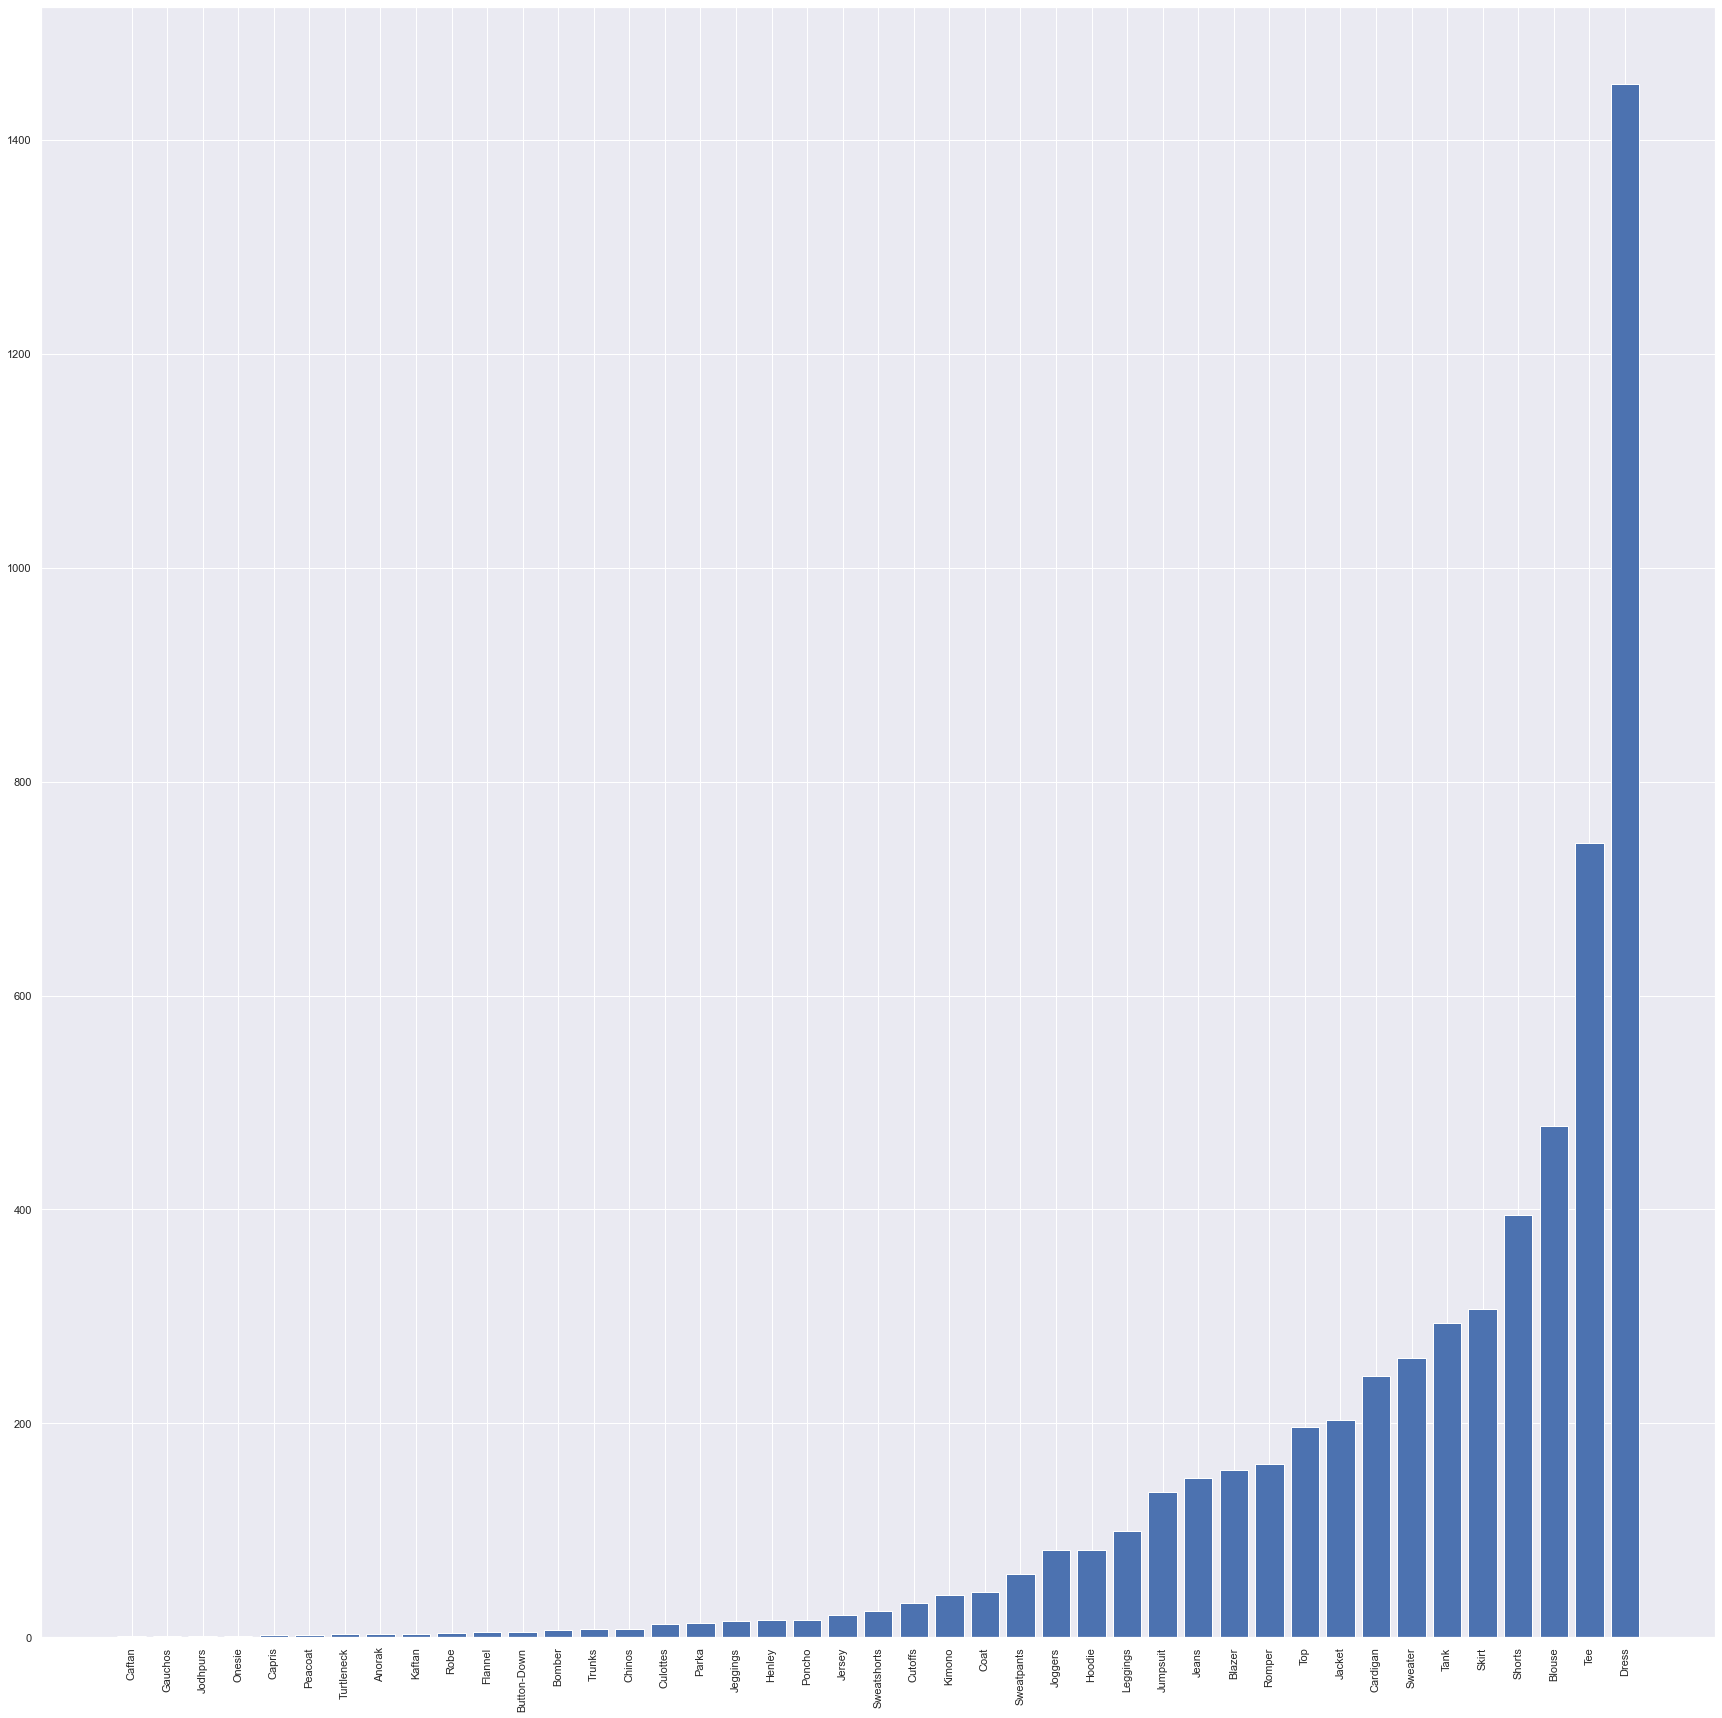

In [45]:
import matplotlib.pyplot as plt

# Ordenar el diccionario por valor (número de imágenes)
sorted_class_count = dict(sorted(class_count.items(), key=lambda item: item[1]))

plt.figure(figsize=(30, 30))  # crea una figura de tamaño 12x8

plt.bar(range(len(sorted_class_count)), list(sorted_class_count.values()), align='center')
plt.xticks(range(len(sorted_class_count)), list(sorted_class_count.keys()), rotation=90)
plt.show()


# Load Metadata

Cada archivo de metadata contiene el path de la imagen, la categoría (columna 'category'), e información sobre los 1000 attributos posibles de textura, materiales, diseño, y estilo. Estos se han codificado como una lista de largo 1000 donde +1 indica que el atributo está -1 que que el atributo no está presente en la imagen de la prenda. La lista completa de atributos está en la columna 'attribute_labels'. Finalmente, los bounding boxes están codificadosn en las columnas x_1', x_2', y_1', y_1' como se muestra en la exploración de las imágenes de más abajo.

In [6]:
train_metadata = pd.read_csv("C:/Users/je00m/Downloads/deepvogue/metadata_train_df.csv")
val_metadata = pd.read_csv("C:/Users/je00m/Downloads/deepvogue/metadata_val_df.csv")
test_metadata = pd.read_csv("C:/Users/je00m/Downloads/deepvogue/metadata_test_df.csv")
reduced_train_metadata = pd.read_csv("C:/Users/je00m/Downloads/deepvogue/metadata_reduced_train_df.csv")

In [7]:
train_metadata.head()

,public_path,category,attribute_labels,x_1,y_1,x_2,y_2
0,train_images/Tee/train_item89910.jpg,Tee,-1 -1 -1 -1 -1 -1 -1 -1 ...,25,69,147,202
1,train_images/Dress/train_item37903.jpg,Dress,-1 -1 -1 -1 -1 -1 -1 -1 -1 -1...,25,56,189,267
2,train_images/Shorts/train_item143571.jpg,Shorts,-1 1 -1 -1 -1 -1 ...,83,96,179,177
3,train_images/Skirt/train_item19072.jpg,Skirt,-1 -1 -1 -1 -1 -...,43,1,170,251
4,train_images/Tee/train_item120248.jpg,Tee,-1 -1 -...,30,56,200,245


In [8]:
val_metadata.head()

,public_path,category,attribute_labels,x_1,y_1,x_2,y_2
0,val_images/Skirt/train_item192144.jpg,Skirt,1 -1 -1 -1 -1 -1 -1 -...,71,93,162,207
1,val_images/Dress/train_item188305.jpg,Dress,-1 -1 -1 -1 -1 -1 -1 -1 ...,33,50,160,234
2,val_images/Blouse/train_item213190.jpg,Blouse,-1 -1 -1 -1 -1 -1 -1 -1 ...,24,98,206,265
3,val_images/Dress/train_item190678.jpg,Dress,-1 -1 -1 -1 -1 -1 -1 -1 -1 ...,18,51,163,282
4,val_images/Skirt/train_item197683.jpg,Skirt,-1 -1 -1 -1 -1 -1 -...,1,114,225,282


In [9]:
test_metadata.head()

,public_path,x_1,y_1,x_2,y_2
0,test_images/test_item0.jpg,23,9,204,187
1,test_images/test_item1.jpg,92,38,217,300
2,test_images/test_item2.jpg,80,1,138,288
3,test_images/test_item3.jpg,29,5,280,300
4,test_images/test_item4.jpg,61,38,167,187


In [11]:
reduced_train_metadata.head()

,public_path,category,attribute_labels,x_1,y_1,x_2,y_2
0,reduced_train_images/Sweater/train_item22691.jpg,Top,-1 -1 -1 -1 -1 ...,79,77,230,244
1,reduced_train_images/Tee/train_item78747.jpg,Tee,-1 -1 -1 -1 -1 -1 -1 -1 -1 -1...,1,1,246,294
2,reduced_train_images/Skirt/train_item32899.jpg,Blouse,-1 -1 -1 -1 -1 -1 -1...,28,19,273,297
3,reduced_train_images/Top/train_item136297.jpg,Tee,-1 -1 -1 -1 -1 -1 -1 -1 ...,68,72,234,259
4,reduced_train_images/Skirt/train_item37497.jpg,Leggings,-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -...,25,11,87,221
...,...,...,...,...,...,...,...
37015,reduced_train_images/Blouse/train_item120441.jpg,Blouse,-1 -1 -1 -1 -1 -1 ...,15,96,214,247
37016,reduced_train_images/Dress/train_item19799.jpg,Jacket,-1 -1 -1 -1 -1 -1 -1...,10,4,239,300
37017,reduced_train_images/Tee/train_item60809.jpg,Sweater,-1 -1 -1 -1 -1 -1 -1 -1 ...,62,25,182,170
37018,reduced_train_images/Tank/train_item142270.jpg,Cardigan,-1 -1 -1 -1 -1 -1 -1 -1 -1 ...,33,84,175,291


Veamos algunos de los 1000 atributos por imagen. Notar que no son excluyentes.

In [8]:
N_LABELS = 1000
counter = 0
show_me = 5
for index, row in train_metadata.iterrows():
  attributes = np.array(row['attribute_labels'].split()).astype(int)
  one_hot = (attributes+1)//2
  print("non zero attributes: ", (one_hot).nonzero())
  if counter>show_me:
    break
  counter+=1

non zero attributes:  (array([226, 227, 365, 373, 601, 688], dtype=int64),)
non zero attributes:  (array([ 42, 811], dtype=int64),)
non zero attributes:  (array([  1,  11, 730], dtype=int64),)
non zero attributes:  (array([596, 608, 717, 984], dtype=int64),)
non zero attributes:  (array([ 44, 954], dtype=int64),)
non zero attributes:  (array([571, 862, 993], dtype=int64),)
non zero attributes:  (array([142, 148, 596, 717, 764], dtype=int64),)


Notas:
Este código muestra algunos de los atributos que están presentes en cada imagen. Primero, convierte la cadena de atributos separados por espacios en una matriz numpy de enteros y luego aplica una transformación de one-hot encoding para obtener un vector binario donde cada posición representa la presencia o ausencia de un atributo. Luego, utiliza la función nonzero() para obtener los índices de los atributos que están presentes en la imagen.

Como se puede observar, cada imagen puede tener múltiples atributos. Los valores en los vectores one-hot no son excluyentes, lo que significa que una imagen puede tener varios atributos a la vez. Por ejemplo, en la primera imagen mostrada, los atributos 226, 227, 365, 373, 601 y 688 están presentes.

# Explore Train Images

In [11]:
"""import matplotlib.patches as patches

showme = 10
size = 10
counter = 0
fig = plt.figure('Ejemplos', figsize=[size,size*10/4]) 
for index, row in train_metadata.iterrows():
  class_name = row['category']
  path_image = row['public_path']
  x1 = row['x_1']; y1 = row['y_1'];
  x2 = row['x_2']; y2 = row['y_2'] 
  w = x2-x1; h = y2-y1;
  image = plt.imread(path_image, format=None)/255.0
  ax = fig.add_subplot(10, 4, counter+1) 
  plt.imshow(image,aspect='auto')
  ax.add_patch(patches.Rectangle((x1, y1), w, h, linewidth=1, edgecolor='r', facecolor='none'))
  plt.grid(None) 
  plt.axis('off')
  plt.title(class_name,fontsize=8) 
  if counter>showme:
    break
  counter+=1
plt.show()"""

"import matplotlib.patches as patches\n\nshowme = 10\nsize = 10\ncounter = 0\nfig = plt.figure('Ejemplos', figsize=[size,size*10/4]) \nfor index, row in train_metadata.iterrows():\n  class_name = row['category']\n  path_image = row['public_path']\n  x1 = row['x_1']; y1 = row['y_1'];\n  x2 = row['x_2']; y2 = row['y_2'] \n  w = x2-x1; h = y2-y1;\n  image = plt.imread(path_image, format=None)/255.0\n  ax = fig.add_subplot(10, 4, counter+1) \n  plt.imshow(image,aspect='auto')\n  ax.add_patch(patches.Rectangle((x1, y1), w, h, linewidth=1, edgecolor='r', facecolor='none'))\n  plt.grid(None) \n  plt.axis('off')\n  plt.title(class_name,fontsize=8) \n  if counter>showme:\n    break\n  counter+=1\nplt.show()"

# Explore Test Images

In [10]:
print(len(test_metadata))

54430


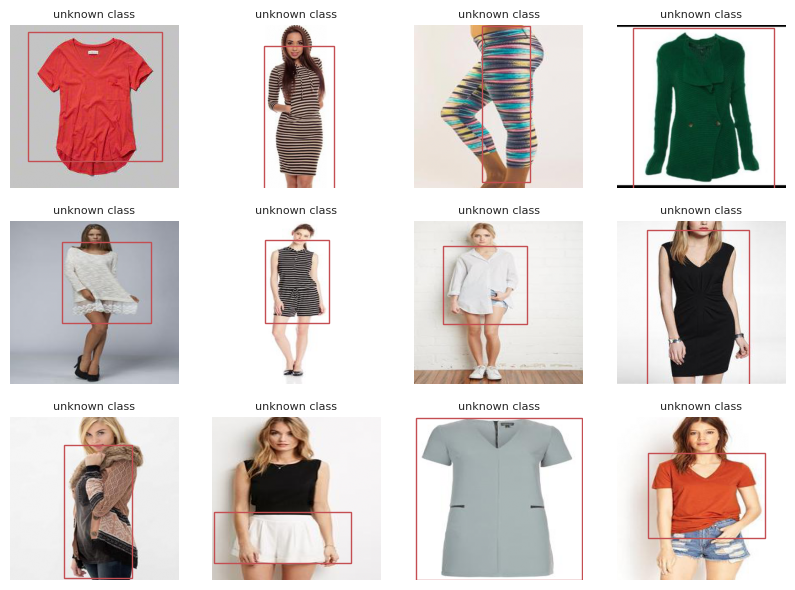

In [26]:
import matplotlib.patches as patches

showme = 10
size = 10
counter = 0
fig = plt.figure('Ejemplos', figsize=[size,size*10/4]) 
for index, row in test_metadata.iterrows():
  path_image = row['public_path']
  x1 = row['x_1']; y1 = row['y_1'];
  x2 = row['x_2']; y2 = row['y_2'] 
  w = x2-x1; h = y2-y1;
  image = plt.imread(path_image, format=None)/255.0
  ax = fig.add_subplot(10, 4, counter+1) 
  plt.imshow(image,aspect='auto')
  ax.add_patch(patches.Rectangle((x1, y1), w, h, linewidth=1, edgecolor='r', facecolor='none'))
  plt.grid(None) 
  plt.axis('off')
  plt.title("unknown class",fontsize=8) 
  if counter>showme:
    break
  counter+=1
plt.show()

Notas:
La congelación de capas consiste en establecer que ciertas capas de la red pre-entrenada no se actualicen durante el entrenamiento del modelo que estamos construyendo. Esto se hace para mantener las características útiles que ya se han aprendido en las capas pre-entrenadas y evitar que se modifiquen durante el entrenamiento de nuestro nuevo modelo.

Notas del alumno: tuvimos la idea de solo trabajar con las k-top categorías pero finalmente entrenamos la red con todas.

In [49]:
"""# Lista de clases seleccionadas
selected_classes = ['Jumpsuit', 'Jeans', 'Blazer','Romper', 'Top', 'Jacket', 'Cardigan', 
                    'Sweater', 'Tank','Skirt', 'Shorts', 'Blouse', 'Tee', 'Dress']

# Crear una lista de imágenes y etiquetas correspondientes solo a las clases seleccionadas
selected_train_images = []
selected_train_labels = []   

for img, label in train_images:s
    class_name = label_names[label.numpy().argmax()]
    if class_name in selected_classes:
        selected_train_images.append(img)
        selected_train_labels.append(label)

# Convertir las listas en un objeto de dataset de TensorFlow
selected_train_ds = tf.data.Dataset.from_tensor_slices((selected_train_images, selected_train_labels))
"""


"# Lista de clases seleccionadas\nselected_classes = ['Jumpsuit', 'Jeans', 'Blazer','Romper', 'Top', 'Jacket', 'Cardigan', \n                    'Sweater', 'Tank','Skirt', 'Shorts', 'Blouse', 'Tee', 'Dress']\n\n# Crear una lista de imágenes y etiquetas correspondientes solo a las clases seleccionadas\nselected_train_images = []\nselected_train_labels = []   \n\nfor img, label in train_images:s\n    class_name = label_names[label.numpy().argmax()]\n    if class_name in selected_classes:\n        selected_train_images.append(img)\n        selected_train_labels.append(label)\n\n# Convertir las listas en un objeto de dataset de TensorFlow\nselected_train_ds = tf.data.Dataset.from_tensor_slices((selected_train_images, selected_train_labels))\n"

### Entrenamiento de la red neuronal ResNet50 en image_data_train

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Cargar los datos de entrenamiento
#ltrain_images = load_data("C:/Users/come_/Documents/UNIVERSIDAD/Redes Neuronales/Taller 2/deepvogue/image_data_train/content/image_data/train_images/",batch_size=BATCH_SIZE, res=RES_ESPACIAL)

# Crear el modelo ResNet50 pre-entrenado
base_model = keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(RES_ESPACIAL, RES_ESPACIAL, CHANNELS)
)

# Congelar las capas de la red pre-entrenada para que no se actualicen durante el entrenamiento
#Se recorren todas las capas del modelo pre-entrenado y se establece el atributo trainable en False, 
#lo que impide que estas capas se actualicen durante el entrenamiento.
for layer in base_model.layers:
    layer.trainable = False

# Agregar una capa de agrupamiento global para reducir la dimensionalidad
global_average_layer = layers.GlobalAveragePooling2D() #capa de agrupamiento global que reduce la dimensionalidad de los mapas de características.
# Agregar una capa densa de 46 unidades con activación softmax para clasificación multiclase
prediction_layer = layers.Dense(46, activation='softmax') #capa densa con 46 unidades (correspondientes a las clases de categorías) y una función de activación softmax para la clasificación multiclase.

# Combinar todas las capas en un modelo secuencial
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

# Compilar el modelo con la función de pérdida categorical_crossentropy, el optimizador Adam y la métrica accuracy
model.compile(optimizer=tf.keras.optimizers.Adam(), #optimizador Adam para ajustar los pesos del modelo durante el entrenamiento.
              loss='categorical_crossentropy', # función de pérdida que se utilizará para optimizar el modelo en un problema de clasificación multiclase.
              metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=100, name='map@100')])

# Entrenar el modelo durante 2 épocas
history = model.fit(train_images, epochs=2)

# Guardar el modelo en un archivo
model.save('my_model_categories_v1.h5')

Epoch 1/2
5785/5785 [==============================] - 10594s 2s/step - loss: 2.0578 - accuracy: 0.4425 - map@100: 1.0000
Epoch 2/2
5785/5785 [==============================] - 10486s 2s/step - loss: 1.8875 - accuracy: 0.4785 - map@100: 1.0000


In [16]:
from keras.models import load_model

# Cargar el modelo desde el archivo
loaded_model = load_model('my_model_categories_v1.h5')

In [20]:
loaded_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 46)                94254     
                                                                 
Total params: 23,681,966
Trainable params: 94,254
Non-trainable params: 23,587,712
_________________________________________________________________


### Ahora empezamos a trabajar con la metadata para la clasificación de los atributos iterando sobre cada categoría:

##### Metadata completa del train set:

Acá cambiamos la columna public_path para que tuviese el path completo y modificado.

In [7]:
csv_file = "C:/Users/je00m/Downloads/deepvogue/metadata_train_df.csv"
image_directory = "C:/Users/je00m/Downloads/deepvogue/image_data_train/content/image_data"

# Leer el archivo CSV
df = pd.read_csv(csv_file)

# Modificar las rutas en el DataFrame
df['public_path'] = image_directory + '/' + df['public_path']

# Guardar el DataFrame modificado en un nuevo archivo CSV
modified_csv_file = "C:/Users/je00m/Downloads/deepvogue/metadata_train_df_modified.csv"
df.to_csv(modified_csv_file, index=False)

In [8]:
# Mostrar la columna 'public_path' que contiene las rutas de las imágenes
metadata_train_df_modified = pd.read_csv("C:/Users/je00m/Downloads/deepvogue/metadata_train_df_modified.csv")

print(metadata_train_df_modified['public_path'])

0         C:/Users/je00m/Downloads/deepvogue/image_data_...
1         C:/Users/je00m/Downloads/deepvogue/image_data_...
2         C:/Users/je00m/Downloads/deepvogue/image_data_...
3         C:/Users/je00m/Downloads/deepvogue/image_data_...
4         C:/Users/je00m/Downloads/deepvogue/image_data_...
                                ...                        
185096    C:/Users/je00m/Downloads/deepvogue/image_data_...
185097    C:/Users/je00m/Downloads/deepvogue/image_data_...
185098    C:/Users/je00m/Downloads/deepvogue/image_data_...
185099    C:/Users/je00m/Downloads/deepvogue/image_data_...
185100    C:/Users/je00m/Downloads/deepvogue/image_data_...
Name: public_path, Length: 185101, dtype: object


##### Metadata reducida del train set:

In [9]:
#reduced_train_metadata


csv_file = "C:/Users/je00m/Downloads/deepvogue/metadata_reduced_train_df.csv"
image_directory = "C:/Users/je00m/Downloads/deepvogue/image_data_reduced_train/content/image_data"

# Leer el archivo CSV
df = pd.read_csv(csv_file)

# Modificar las rutas en el DataFrame
df['public_path'] = image_directory + '/' + df['public_path']

# Guardar el DataFrame modificado en un nuevo archivo CSV
modified_csv_file = "C:/Users/je00m/Downloads/deepvogue/metadata_reduced_train_df_modified.csv"
df.to_csv(modified_csv_file, index=False)

In [10]:
metadata_reduced_train_df_modified = pd.read_csv("C:/Users/je00m/Downloads/deepvogue/metadata_reduced_train_df_modified.csv")


In [11]:
# Mostrar la columna 'public_path' que contiene las rutas de las imágenes solo para chequear que se hayan guardado bien-

print(metadata_reduced_train_df_modified['public_path'])

0        C:/Users/je00m/Downloads/deepvogue/image_data_...
1        C:/Users/je00m/Downloads/deepvogue/image_data_...
2        C:/Users/je00m/Downloads/deepvogue/image_data_...
3        C:/Users/je00m/Downloads/deepvogue/image_data_...
4        C:/Users/je00m/Downloads/deepvogue/image_data_...
                               ...                        
37015    C:/Users/je00m/Downloads/deepvogue/image_data_...
37016    C:/Users/je00m/Downloads/deepvogue/image_data_...
37017    C:/Users/je00m/Downloads/deepvogue/image_data_...
37018    C:/Users/je00m/Downloads/deepvogue/image_data_...
37019    C:/Users/je00m/Downloads/deepvogue/image_data_...
Name: public_path, Length: 37020, dtype: object


Por otro lado, intentamos usar el algoritmo Faiss para categorizar los atributos pero tuvimos error de memoria. Dejamos el código como prueba.

In [47]:
"""import faiss
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Cargar el modelo entrenado
loaded_model = load_model('my_model_categories_v1.h5')

# Definir el tamaño de las imágenes de entrada esperadas por el modelo
input_shape = (128, 128)

# Cargar los datos de metadata_train
metadata_train = pd.read_csv("C:/Users/come_/Documents/UNIVERSIDAD/Redes Neuronales/Taller 2/deepvogue/metadata_train_df_modified.csv")

# Función para cargar y redimensionar las imágenes en lotes
def load_and_preprocess_images(image_paths):
    images = []
    for path in image_paths:
        image = load_img(path, target_size=input_shape)
        image = img_to_array(image)
        image = image / 255.0  # Normalizar los valores de píxel en el rango [0, 1]
        images.append(image)
    return np.array(images)

# Obtener las predicciones de categoría para metadata_train
batch_size = 1000
num_samples = len(metadata_train)
predictions = []
for i in range(0, num_samples, batch_size):
    batch_paths = metadata_train['public_path'].values[i:i+batch_size]
    batch_images = load_and_preprocess_images(batch_paths)
    batch_predictions = loaded_model.predict(batch_images)
    predictions.append(batch_predictions)
predictions = np.concatenate(predictions)

# Obtener las categorías únicas del modelo
categories = loaded_model.classes_

# Crear el DataFrame de predicciones
predictions_df = pd.DataFrame(columns=['Id', 'Predicted'])

# Iterar sobre cada categoría
for category in categories:
    # Filtrar los datos para la categoría actual
    category_data = metadata_train[metadata_train['category'] == category]
    
    # Extraer los atributos relevantes para Faiss
    attributes = category_data['attribute_labels'].values
    
    # Cargar el índice de búsqueda de Faiss entrenado previamente
    index = faiss.read_index(f'{category}_index.faiss')
    
    # Realizar la búsqueda de los k vecinos más cercanos
    k = 100
    distances, indices = index.search(attributes, k)
    
    # Convertir los índices de los vecinos en una cadena de texto
    neighbor_ids = [' '.join(map(str, category_data.iloc[ind]['id'])) for ind in indices]
    
    # Agregar las predicciones para la categoría actual al DataFrame de predicciones
    category_predictions = pd.DataFrame({'Id': category_data.index, 'Predicted': neighbor_ids})
    predictions_df = predictions_df.append(category_predictions)

# Guardar el DataFrame de predicciones en un archivo CSV
predictions_df.to_csv('empty_solution_file.csv', index=False)

# Crear el archivo de solución
solution_df = pd.DataFrame({'Id': metadata_train.index})
solution_df.to_csv('solution_file.csv', index=False)
"""

'import faiss\nimport pandas as pd\nimport numpy as np\nfrom tensorflow.keras.models import load_model\nfrom tensorflow.keras.preprocessing.image import load_img, img_to_array\n\n# Cargar el modelo entrenado\nloaded_model = load_model(\'my_model_categories_v1.h5\')\n\n# Definir el tamaño de las imágenes de entrada esperadas por el modelo\ninput_shape = (128, 128)\n\n# Cargar los datos de metadata_train\nmetadata_train = pd.read_csv("C:/Users/come_/Documents/UNIVERSIDAD/Redes Neuronales/Taller 2/deepvogue/metadata_train_df_modified.csv")\n\n# Función para cargar y redimensionar las imágenes en lotes\ndef load_and_preprocess_images(image_paths):\n    images = []\n    for path in image_paths:\n        image = load_img(path, target_size=input_shape)\n        image = img_to_array(image)\n        image = image / 255.0  # Normalizar los valores de píxel en el rango [0, 1]\n        images.append(image)\n    return np.array(images)\n\n# Obtener las predicciones de categoría para metadata_train\

In [147]:
"""def preprocess_metadata(metadata):
    # Obtener los atributos de la columna 'attribute_labels'
    attributes = metadata['attribute_labels'].values
    
    # Convertir los atributos en una matriz NumPy de tipo float32
    processed_attributes = np.array([list(map(float, attr.split())) for attr in attributes], dtype=np.float32)
    
    # Devolver los atributos preprocesados
    return processed_attributes
"""

"def preprocess_metadata(metadata):\n    # Obtener los atributos de la columna 'attribute_labels'\n    attributes = metadata['attribute_labels'].values\n    \n    # Convertir los atributos en una matriz NumPy de tipo float32\n    processed_attributes = np.array([list(map(float, attr.split())) for attr in attributes], dtype=np.float32)\n    \n    # Devolver los atributos preprocesados\n    return processed_attributes\n"

##### Ahora trabajamos sobre la columna attribute_labels cambiando los -1 por 0 y los 1 dejándolos igual.

In [17]:
# Iterar sobre cada fila y cambiar los -1 por 0
def replace_negative(row):
    """
    Reemplaza los valores negativos en una fila por '0'.

    Parámetros:
        row (str): fila de entrada que contiene valores separados por espacios.

    Returns:
        str: fila modificada con los valores negativos reemplazados por '0'.
    """
    values = row.split(' ')
    modified_values = ['0' if value == '-1' else value for value in values]
    return ' '.join(modified_values)

# Aplicar la función a la columna attribute_labels:
metadata_reduced_train_df_modified['attribute_labels'] = metadata_reduced_train_df_modified['attribute_labels'].apply(replace_negative)


In [18]:
metadata_reduced_train_df_modified['attribute_labels'][0] #chequeo

'                               0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [20]:
metadata_reduced_train_df_modified.head() #chequeo

,public_path,category,attribute_labels,x_1,y_1,x_2,y_2
0,C:/Users/come_/Documents/UNIVERSIDAD/Redes Neu...,Top,0 0 0 0 0 0 0 0...,79,77,230,244
1,C:/Users/come_/Documents/UNIVERSIDAD/Redes Neu...,Tee,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,1,1,246,294
2,C:/Users/come_/Documents/UNIVERSIDAD/Redes Neu...,Blouse,0 0 0 0 0 0 0 0 0 0 ...,28,19,273,297
3,C:/Users/come_/Documents/UNIVERSIDAD/Redes Neu...,Tee,0 0 0 0 0 0 0 0 0 0 0 0 ...,68,72,234,259
4,C:/Users/come_/Documents/UNIVERSIDAD/Redes Neu...,Leggings,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,25,11,87,221
...,...,...,...,...,...,...,...
37015,C:/Users/come_/Documents/UNIVERSIDAD/Redes Neu...,Blouse,0 0 0 0 0 0 0 0 0 ...,15,96,214,247
37016,C:/Users/come_/Documents/UNIVERSIDAD/Redes Neu...,Jacket,0 0 0 0 0 0 0 0 0 0 ...,10,4,239,300
37017,C:/Users/come_/Documents/UNIVERSIDAD/Redes Neu...,Sweater,0 0 0 0 0 0 0 0 0 0 0 0 ...,62,25,182,170
37018,C:/Users/come_/Documents/UNIVERSIDAD/Redes Neu...,Cardigan,0 0 0 0 0 0 0 0 0 0 0 0 0 0...,33,84,175,291


In [49]:
"""#CORRERLO
import tensorflow as tf
from tensorflow.keras.models import load_model

# Cargar el modelo entrenado
model = load_model('my_model_categories_v1.h5')

# Obtener las predicciones en el conjunto de validación
val_predictions = model.predict(val_images)

# Obtener las categorías predichas por el modelo
predicted_categories = tf.argmax(val_predictions, axis=1).numpy()

# Imprimir las predicciones
print(predicted_categories)"""


"#CORRERLO\nimport tensorflow as tf\nfrom tensorflow.keras.models import load_model\n\n# Cargar el modelo entrenado\nmodel = load_model('my_model_categories_v1.h5')\n\n# Obtener las predicciones en el conjunto de validación\nval_predictions = model.predict(val_images)\n\n# Obtener las categorías predichas por el modelo\npredicted_categories = tf.argmax(val_predictions, axis=1).numpy()\n\n# Imprimir las predicciones\nprint(predicted_categories)"

##### Preprocesamiento de las imágenes y de los bounding boxes:

In [61]:
def load_and_preprocess_images(image_paths):
    """
    Carga y preprocesa las imágenes desde una lista de rutas de imagen.

    Parameters:
        image_paths (list): lista de rutas de imagen.

    Returns:
        numpy.ndarray: array de imágenes preprocesadas.

    """
    images = []
    for path in image_paths:
        image = load_img(path, target_size=input_shape)
        image = img_to_array(image) #convierte la imagen en una matriz NumPy donde cada elemento representa el valor de un píxel en la imagen.
        image = image / 255.0  # Normalizar los valores de píxel en el rango [0, 1]
        images.append(image)
    return np.array(images) #devuelve array de imágenes

In [22]:
def preprocess_bounding_boxes(row):
    """
    Realiza el preprocesamiento de las coordenadas de los bounding boxes de una imagen.

    Parámetros:
        row (pandas.Series): fila del dataframe que contiene las coordenadas del bounding box.

    Returns:
        numpy.ndarray: array 2D con las coordenadas preprocesadas del bounding box en formato float32.
    """
    
    image_paths = row['public_path']
    if isinstance(image_paths, str): #se verifica si image_paths es una cadena (str).
        image_paths = [image_paths]  # convierte la ruta de archivo en una lista
    
    #image_paths = row['public_path']
    x1, y1, x2, y2 = row['x_1'], row['y_1'], row['x_2'], row['y_2']
    
    # Cargar la imagen y obtener sus dimensiones
    image = load_and_preprocess_images(image_paths)  #función de carga y preprocesamiento de imágenes
    image_height, image_width = image.shape[:2]  #se obtienen las dimensiones de altura y ancho de la imagen
    
    # Convertir las coordenadas a tipo float32
    x1 = np.float32(x1)
    y1 = np.float32(y1)
    x2 = np.float32(x2)
    y2 = np.float32(y2)
    
    # Calcular las coordenadas del centro y el ancho y alto del bounding box
    cx = (x1 + x2) / 2 #se calculan las coordenadas del centro del bounding box
    cy = (y1 + y2) / 2
    w = x2 - x1 #ancho
    h = y2 - y1 #altura
    
    #normaliza las coordenadas en el rango [0, 1] en función del tamaño de la imagen
    #se normalizan las coordenadas y tamaños del bounding box dividiéndolos entre la anchura (image_width) y altura (image_height) de la imagen.
    cx /= image_width
    cy /= image_height
    w /= image_width
    h /= image_height
    
    # Devolver las coordenadas preprocesadas como un array 2D
    return np.array([[cx, cy, w, h]], dtype=np.float32)



# Definir el tamaño de las imágenes de entrada esperadas por el modelo
input_shape = (128, 128)

In [24]:
metadata_reduced_train_df_modified['bounding_boxes'] = metadata_reduced_train_df_modified.apply(preprocess_bounding_boxes, axis=1)


In [58]:
metadata_reduced_train_df_modified

,public_path,category,attribute_labels,x_1,y_1,x_2,y_2,bounding_boxes
0,C:/Users/come_/Documents/UNIVERSIDAD/Redes Neu...,Top,0 0 0 0 0 0 0 0...,79,77,230,244,"[[1.2070312, 160.5, 1.1796875, 167.0]]"
1,C:/Users/come_/Documents/UNIVERSIDAD/Redes Neu...,Tee,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,1,1,246,294,"[[0.96484375, 147.5, 1.9140625, 293.0]]"
2,C:/Users/come_/Documents/UNIVERSIDAD/Redes Neu...,Blouse,0 0 0 0 0 0 0 0 0 0 ...,28,19,273,297,"[[1.1757812, 158.0, 1.9140625, 278.0]]"
3,C:/Users/come_/Documents/UNIVERSIDAD/Redes Neu...,Tee,0 0 0 0 0 0 0 0 0 0 0 0 ...,68,72,234,259,"[[1.1796875, 165.5, 1.296875, 187.0]]"
4,C:/Users/come_/Documents/UNIVERSIDAD/Redes Neu...,Leggings,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,25,11,87,221,"[[0.4375, 116.0, 0.484375, 210.0]]"
...,...,...,...,...,...,...,...,...
37015,C:/Users/come_/Documents/UNIVERSIDAD/Redes Neu...,Blouse,0 0 0 0 0 0 0 0 0 ...,15,96,214,247,"[[0.89453125, 171.5, 1.5546875, 151.0]]"
37016,C:/Users/come_/Documents/UNIVERSIDAD/Redes Neu...,Jacket,0 0 0 0 0 0 0 0 0 0 ...,10,4,239,300,"[[0.97265625, 152.0, 1.7890625, 296.0]]"
37017,C:/Users/come_/Documents/UNIVERSIDAD/Redes Neu...,Sweater,0 0 0 0 0 0 0 0 0 0 0 0 ...,62,25,182,170,"[[0.953125, 97.5, 0.9375, 145.0]]"
37018,C:/Users/come_/Documents/UNIVERSIDAD/Redes Neu...,Cardigan,0 0 0 0 0 0 0 0 0 0 0 0 0 0...,33,84,175,291,"[[0.8125, 187.5, 1.109375, 207.0]]"


#### Primer intento de entrenar los atributos:
se nos reinició el computador así que perdimos parte del código, pero comenzaba así:

In [22]:
#PARA CARGAR IMÁGENES Y LABELS 
from tensorflow.keras.preprocessing import image

folder = 'C:/Users/je00m/Downloads/deepvogue/image_data_test/'

# Lista para almacenar las imágenes
test_images = []

# Recorrer los archivos en el directorio
for filename in os.listdir(folder):
    # Cargar la imagen utilizando load_img
    img = image.load_img(os.path.join(folder, filename))
    # Agregar la imagen a la lista
    test_images.append(img)

# Ahora se tienen todas las imágenes cargadas en la lista test_images


In [19]:
from tensorflow.keras.models import load_model

# Cargar el modelo entrenado
loaded_model = load_model('my_model_categories_v1.h5')

# Imprimir la arquitectura del modelo
print(loaded_model.summary())

# Imprimir la forma de entrada esperada por el modelo
print(loaded_model.input_shape)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 46)                94254     
                                                                 
Total params: 23,681,966
Trainable params: 94,254
Non-trainable params: 23,587,712
_________________________________________________________________
None
(None, 128, 128, 3)


In [ ]:
# Crear un DataFrame con las predicciones
#predictions_df = pd.DataFrame({'Id': train_metadata.index, 'Expected': [' '.join(map(str, attrs)) for attrs in attribute_predictions]})

#### Otro enfoque:
Intentamos con Kmeans con 10 clusters pero se demoró un poco. Por ello, no lo hicimos con los 1000 clusters. Pero aquí un ejemplo de esta idea que teníamos. Claramente, no la mejor idea.

In [86]:
import pandas as pd
from sklearn.cluster import KMeans

# Cargar el dataset
metadata_df = pd.read_csv("metadata_reduced_train_df_modified.csv")

# Obtener la columna "attribute_labels"
attribute_labels = metadata_df["attribute_labels"]

# Convertir la columna en una matriz de características
X = []
for labels in attribute_labels:
    labels_list = list(map(int, labels.split()))
    X.append(labels_list)
X = pd.DataFrame(X)

# Aplicar el algoritmo K-Means
kmeans = KMeans(n_clusters=10, random_state=0)
kmeans.fit(X)

# Obtener las etiquetas de los clusters asignados a cada muestra
cluster_labels = kmeans.labels_

# Agregar las etiquetas de los clusters al dataset original
metadata_df["cluster_label"] = cluster_labels

# Guardar el dataset con las etiquetas de los clusters
metadata_df.to_csv("metadata_clusters.csv", index=False)


In [87]:
metadata_clusters = pd.read_csv("metadata_clusters.csv")

In [88]:
metadata_clusters.head()

,public_path,category,attribute_labels,x_1,y_1,x_2,y_2,cluster_label
0,C:/Users/come_/Documents/UNIVERSIDAD/Redes Neu...,Top,-1 -1 -1 -1 -1 ...,79,77,230,244,4
1,C:/Users/come_/Documents/UNIVERSIDAD/Redes Neu...,Tee,-1 -1 -1 -1 -1 -1 -1 -1 -1 -1...,1,1,246,294,5
2,C:/Users/come_/Documents/UNIVERSIDAD/Redes Neu...,Blouse,-1 -1 -1 -1 -1 -1 -1...,28,19,273,297,4
3,C:/Users/come_/Documents/UNIVERSIDAD/Redes Neu...,Tee,-1 -1 -1 -1 -1 -1 -1 -1 ...,68,72,234,259,4
4,C:/Users/come_/Documents/UNIVERSIDAD/Redes Neu...,Leggings,-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -...,25,11,87,221,4


C:\Users\come_\AppData\Local\Temp\ipykernel_3552\3224213411.py:22: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(ticks=range(len(cluster_labels)))
Locator attempting to generate 37020 ticks ([0, ..., 37019]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 37020 ticks ([0, ..., 37019]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 37020 ticks ([0, ..., 37019]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 37020 ticks ([0, ..., 37019]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 37020 ticks ([0, ..., 37019]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 37020 ticks ([0, ..., 37019]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 37020 ticks ([0, ..., 37019]), which exceeds Locator.MAXTICKS (10

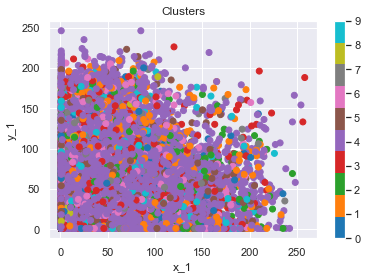

In [89]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el dataset con las etiquetas de los clusters
metadata_clusters_df = pd.read_csv("metadata_clusters.csv")

# Obtener las coordenadas x e y para el scatter plot
x = metadata_clusters_df["x_1"]
y = metadata_clusters_df["y_1"]

# Obtener las etiquetas de los clusters
cluster_labels = metadata_clusters_df["cluster_label"]

# Crear un colormap para asignar colores a cada cluster
colors = plt.cm.get_cmap("tab10", len(cluster_labels))

# Graficar el scatter plot con colores según los clusters
plt.scatter(x, y, c=cluster_labels, cmap=colors)
plt.xlabel("x_1")
plt.ylabel("y_1")
plt.title("Clusters")
plt.colorbar(ticks=range(len(cluster_labels)))
plt.show()


#### Otro enfoque más:

In [23]:
import pandas as pd
import numpy as np
import tensorflow as tf

# Cargar el dataset
metadata_df = pd.read_csv("metadata_reduced_train_df_modified.csv")

# Obtener las imágenes y los atributos
image_paths = metadata_df["public_path"].tolist()
attributes = metadata_df["attribute_labels"].tolist()

# Cargar y preprocesar las imágenes
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_image(image_path):
    # Cargar la imagen usando load_img()
    img = load_img(image_path, target_size=(RES_ESPACIAL, RES_ESPACIAL))
  
    # Convertir la imagen a un array numpy usando img_to_array()
    img_array = img_to_array(img)
    
    # Realizar cualquier otro preprocesamiento necesario, como normalización o transformaciones de datos

    return img_array


# Crear los arrays de imágenes y atributos
images = np.array([load_image(path) for path in image_paths])
attributes = np.array(attributes)

# Dividir los datos en conjuntos de entrenamiento y validación
train_images = images[:30000]
train_attributes = attributes[:30000]
val_images = images[30000:]
val_attributes = attributes[30000:]

# Normalizar los valores de píxeles de las imágenes (opcional)
train_images = train_images / 255.0
val_images = val_images / 255.0


FileNotFoundError: [Errno 2] No such file or directory: 'metadata_reduced_train_df_modified.csv'

In [16]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Cargar el modelo ResNet50 pre-entrenado
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(RES_ESPACIAL, RES_ESPACIAL, CHANNELS)
)

# Congelar las capas del modelo base para que no se actualicen durante el entrenamiento
for layer in base_model.layers:
    layer.trainable = False

# Agregar una capa de agrupamiento global
global_average_layer = GlobalAveragePooling2D()(base_model.output)

# Agregar una capa densa para la clasificación de atributos
attribute_prediction_layer = Dense(NUM_CLASSES, activation='softmax')(global_average_layer)

# Combinar el modelo base con la capa de predicción de atributos
model = Model(inputs=base_model.input, outputs=attribute_prediction_layer)

# Compilar el modelo con la función de pérdida y el optimizador adecuados
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


NameError: name 'NUM_CLASSES' is not defined

In [15]:
train_attributes = pd.DataFrame(train_attributes)
val_attributes = pd.DataFrame(val_attributes)

NameError: name 'train_attributes' is not defined

In [14]:
train_attributes = train_attributes.applymap(lambda x: [int(value) for value in x.split()])
val_attributes = val_attributes.applymap(lambda x: [int(value) for value in x.split()])


NameError: name 'train_attributes' is not defined

In [13]:
# Convertir los atributos en una lista de cadenas
train_attributes_str = train_attributes.apply(lambda x: ' '.join(map(str, x))).tolist()
val_attributes_str = val_attributes.apply(lambda x: ' '.join(map(str, x))).tolist()


NameError: name 'train_attributes' is not defined

Y en el siguiente recuadro no pudo correr porque nos quedamos sin memoria :( #memoryerror

In [12]:
from sklearn.preprocessing import OneHotEncoder

# Crear y ajustar el codificador one-hot
encoder = OneHotEncoder(sparse=False)
encoder.fit(train_attributes_str)

# Codificar los atributos utilizando el codificador
train_attributes_one_hot = encoder.transform(train_attributes_str)
val_attributes_one_hot = encoder.transform(val_attributes_str)

NameError: name 'train_attributes_str' is not defined

In [103]:
# Convertir los atributos en one-hot encoding (opcional, dependiendo de cómo estén representados)
train_attributes_one_hot = tf.keras.utils.to_categorical(train_attributes)
val_attributes_one_hot = tf.keras.utils.to_categorical(val_attributes)

# Entrenar el modelo
history = model.fit(train_images, train_attributes_one_hot, validation_data=(val_images, val_attributes_one_hot), epochs=10, batch_size=32)


ValueError: setting an array element with a sequence.